<a href="https://colab.research.google.com/github/inesbsilveira/2nd-semester-2023/blob/main/IS_MC_code_img_segmentation_workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code for Image segmentation task for Practical Machine Learning
#### Inês Silveira nr. 22062


## First of all, download the files **mask_reclass.tif** and **3bands_clipped_tif.tif**, from the Data_In folder, to path /content/drive/MyDrive/AAA/ in Google Colab.

## Imports

In [ ]:
user='M' # escolher
target_names=['Nao estufa','Estufa']

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio

import rasterio
from rasterio.windows import Window
import os
import shutil
import numpy as np
from PIL import Image

from fastai.vision.all import *
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## RASTERIO

### RASTERIO - 1 BAND IMAGE
Used to clip the mask_reclass.tif into smaller images. It creates a folder named "labels1" and stores all the 160 clipped images inside.

In [ ]:
# Specify the directory path
if user=='M':
  directory = '/content/drive/MyDrive/inv_proj/S2change_DGT/Estufas_Alentejo'
else:
  directory = '/content/drive/MyDrive/AAA/'

# Create a folder named "labels1" if it doesn't exist
folder_name = "labels1"
folder_path = os.path.join(directory, folder_name)
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)  # Delete the folder and its contents

os.makedirs(folder_path)  # Create the folder

# Open the input raster file
#with rasterio.open('/content/drive/MyDrive/AAA/mask_reclass.tif') as src:
with rasterio.open(os.path.join(directory,'mask_reclass.tif')) as src:

    # Calculate the height and width of the sub-rasters
    height = src.height // 20  # Divide the raster into 4 rows
    width = src.width // 8  # Divide the raster into 8 columns

    # Loop through each sub-raster and clip the data
    for i in range(20):
        for j in range(8):
            # Define the window to clip the sub-raster
            ymin = i * height
            ymax = (i + 1) * height
            xmin = j * width
            xmax = (j + 1) * width
            window = Window.from_slices((ymin, ymax), (xmin, xmax))

            # Read the data within the window
            clipped_data = src.read(window=window)

            # Update the metadata for the clipped data
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                'height': window.height,
                'width': window.width,
                'transform': src.window_transform(window)
            })

            # Write the clipped data to a new raster file
            # with rasterio.open(f'sub_raster_{i}_{j}.tif', 'w', **clipped_meta) as dst:
            output_file = os.path.join(directory,folder_name, f'image_{i}_{j}_mask1.png')
            with rasterio.open(output_file, 'w', **clipped_meta) as dst:
                 dst.write(clipped_data)

  # converts to 8 bits AFTER re-scaling bands
def s255(arr):
    arr_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    # Convert the standardized array to integer values
    arr_std = arr_std.astype(np.uint8)
    return arr_std

### RASTERIO - 3 BANDS IMAGE
Used to clip the 3bands_clipped_tif.tif into smaller images. It creates a folder named "images" and stores all the 160 clipped images inside.

In [ ]:
# Specify the directory path
# directory = '/content/drive/MyDrive/AAA/'

# Create a folder named "images" if it already doesn't exist
folder_name = "images"
folder_path = os.path.join(directory, folder_name)
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)  # Delete the folder and its contents

os.makedirs(folder_path)  # Create the folder

# Multi bandas
# Open the input raster file
with rasterio.open(os.path.join(directory,'3bands_clipped_tif.tif')) as src:

    # Calculate the height and width of the sub-rasters
    nHeight=20
    nWidth=8
    height = src.height // nHeight  # Divide the raster into 58 rows
    width = src.width // nWidth  # Divide the raster into 23 columns

    # Loop through each sub-raster and clip the data
    for i in range(nHeight):
        for j in range(nWidth):
            # Define the window to clip the sub-raster
            ymin = i * height
            ymax = (i + 1) * height
            xmin = j * width
            xmax = (j + 1) * width

            window = Window.from_slices((ymin, ymax), (xmin, xmax))

            # Read the data within the window
            clipped_data_1 = s255(src.read(1, window=window))
            clipped_data_2 = s255(src.read(2, window=window))
            clipped_data_3 = s255(src.read(3, window=window))

            rgb_image = np.stack([clipped_data_1, clipped_data_2, clipped_data_3], axis=2)


            # Convert the image array to a PIL Image
            image = Image.fromarray(rgb_image,mode='RGB')

            # Save the PIL Image as a PNG file

            output_file = os.path.join(directory, folder_name, f'image_{i}_{j}.png')
            image.save(output_file)

## IMAGE SEGMENTATION
Uses images and labels created in the previous code, as well as a list of labels in the mask (greenhouse, not greenhouse)

In [4]:
# Define paths
path = Path('/content/drive/MyDrive/AAA')
#path=Path(directory)
image_folder = path/'images'
mask_folder = path/'labels1'

# Create DataBlock
def get_items(path):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    return mask_folder / f'{image_file.stem}_mask1.png'

codes = ['greenhouse', 'not greenhouse']  # Labels in the mask

items = get_items(path)

# Create a stratified split of the indices for training and test set
train_idx, test_idx = RandomSplitter(valid_pct=0.2, seed=42)(items)
train_items = [items[i] for i in train_idx]
test_items = [items[i] for i in test_idx]

# Write the training set items to a txt file
with open('training_set.txt', 'w') as f:
    for item in train_items:
        f.write(str(item) + '\n')

# Write the test set items to a txt file
with open('test_set.txt', 'w') as f:
    for item in test_items:
        f.write(str(item) + '\n')

print("Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.")


Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.


In [5]:


dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(path, bs=8)

Train the model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 71.5MB/s]


epoch,train_loss,valid_loss,time
0,0.443002,0.336507,01:05


epoch,train_loss,valid_loss,time
0,0.356487,0.365264,00:01
1,0.360469,0.380395,00:02


<Axes: >

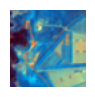

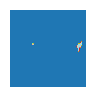

In [6]:
# Define U-Net model
learn = unet_learner(dls, resnet34)

# Train the model
# In the following line of code, adjust the number of epochs to see different results
learn.fine_tune(2)

# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder))
preds = learn.get_preds(dl=test_dl)

# Display sample predictions
sample_idx = 0
sample_image_path = list(test_dl.items)[sample_idx]
sample_image = PILImage.create(sample_image_path)
sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

sample_image.show()
TensorImage(sample_pred).show(cmap='tab20')


In [7]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder))
preds = learn.get_preds(dl=test_dl)[0]

In [8]:
# Define the function to extract the row and column number from the test image file name
def get_row_column_from_filename(filename):
    filename = os.path.basename(filename)
    parts = filename.split('_')
    row = int(parts[1])
    column = int(parts[2].split('.')[0])
    return row, column

In [ ]:
# Save the predicted mask images according to their row and column number
for idx, pred in enumerate(preds):
    # Get the row and column number from the test image file name
    sample_image_path = list(test_dl.items)[idx]
    row, column = get_row_column_from_filename(sample_image_path)

    # Create a folder for each row if it doesn't exist
    row_folder = os.path.join(mask_folder, f'row_{row}')
    os.makedirs(row_folder, exist_ok=True)

    # Create a filename for the predicted mask image
    mask_filename = f'image_{row}_{column}_mask1.png'
    mask_filepath = os.path.join(row_folder, mask_filename)

    # Convert the predicted mask to a PIL Image
    sample_pred = pred.argmax(dim=0).numpy()
    mask_image = Image.fromarray((sample_pred * 255).astype(np.uint8))

    # Save the predicted mask image
    mask_image.save(mask_filepath)

In [ ]:
# Open the input raster file to calculate width and height
#with rasterio.open('/content/drive/MyDrive/AAA/mask_reclass.tif') as src:
with rasterio.open(os.path.join(directory,'mask_reclass.tif')) as src:
    # Calculate the height and width of the sub-rasters
    height = src.height // 20  # Divide the raster into 4 rows
    width = src.width // 8  # Divide the raster into 8 columns

In [ ]:
# Merge all predicted mask images according to their row and column
rows, columns = 20, 8  # Number of rows and columns in the grid
merged_width = width * columns
merged_height = height * rows
merged_image = Image.new('RGB', (merged_width, merged_height))

# Loop through each row and column to merge the images
for i in range(rows):
    for j in range(columns):
        # Load the predicted mask image
        mask_file = os.path.join(mask_folder, f'row_{i}', f'image_{i}_{j}_mask1.png')
        mask_image = Image.open(mask_file)

        # Define the position to paste the mask image in the merged image
        x_offset = j * width
        y_offset = i * height

        # Paste the mask image in the merged image
        merged_image.paste(mask_image, (x_offset, y_offset))

# Save the merged image
merged_output_file = os.path.join(mask_folder, 'merged_predicted_masks_50.png')
merged_image.save(merged_output_file)


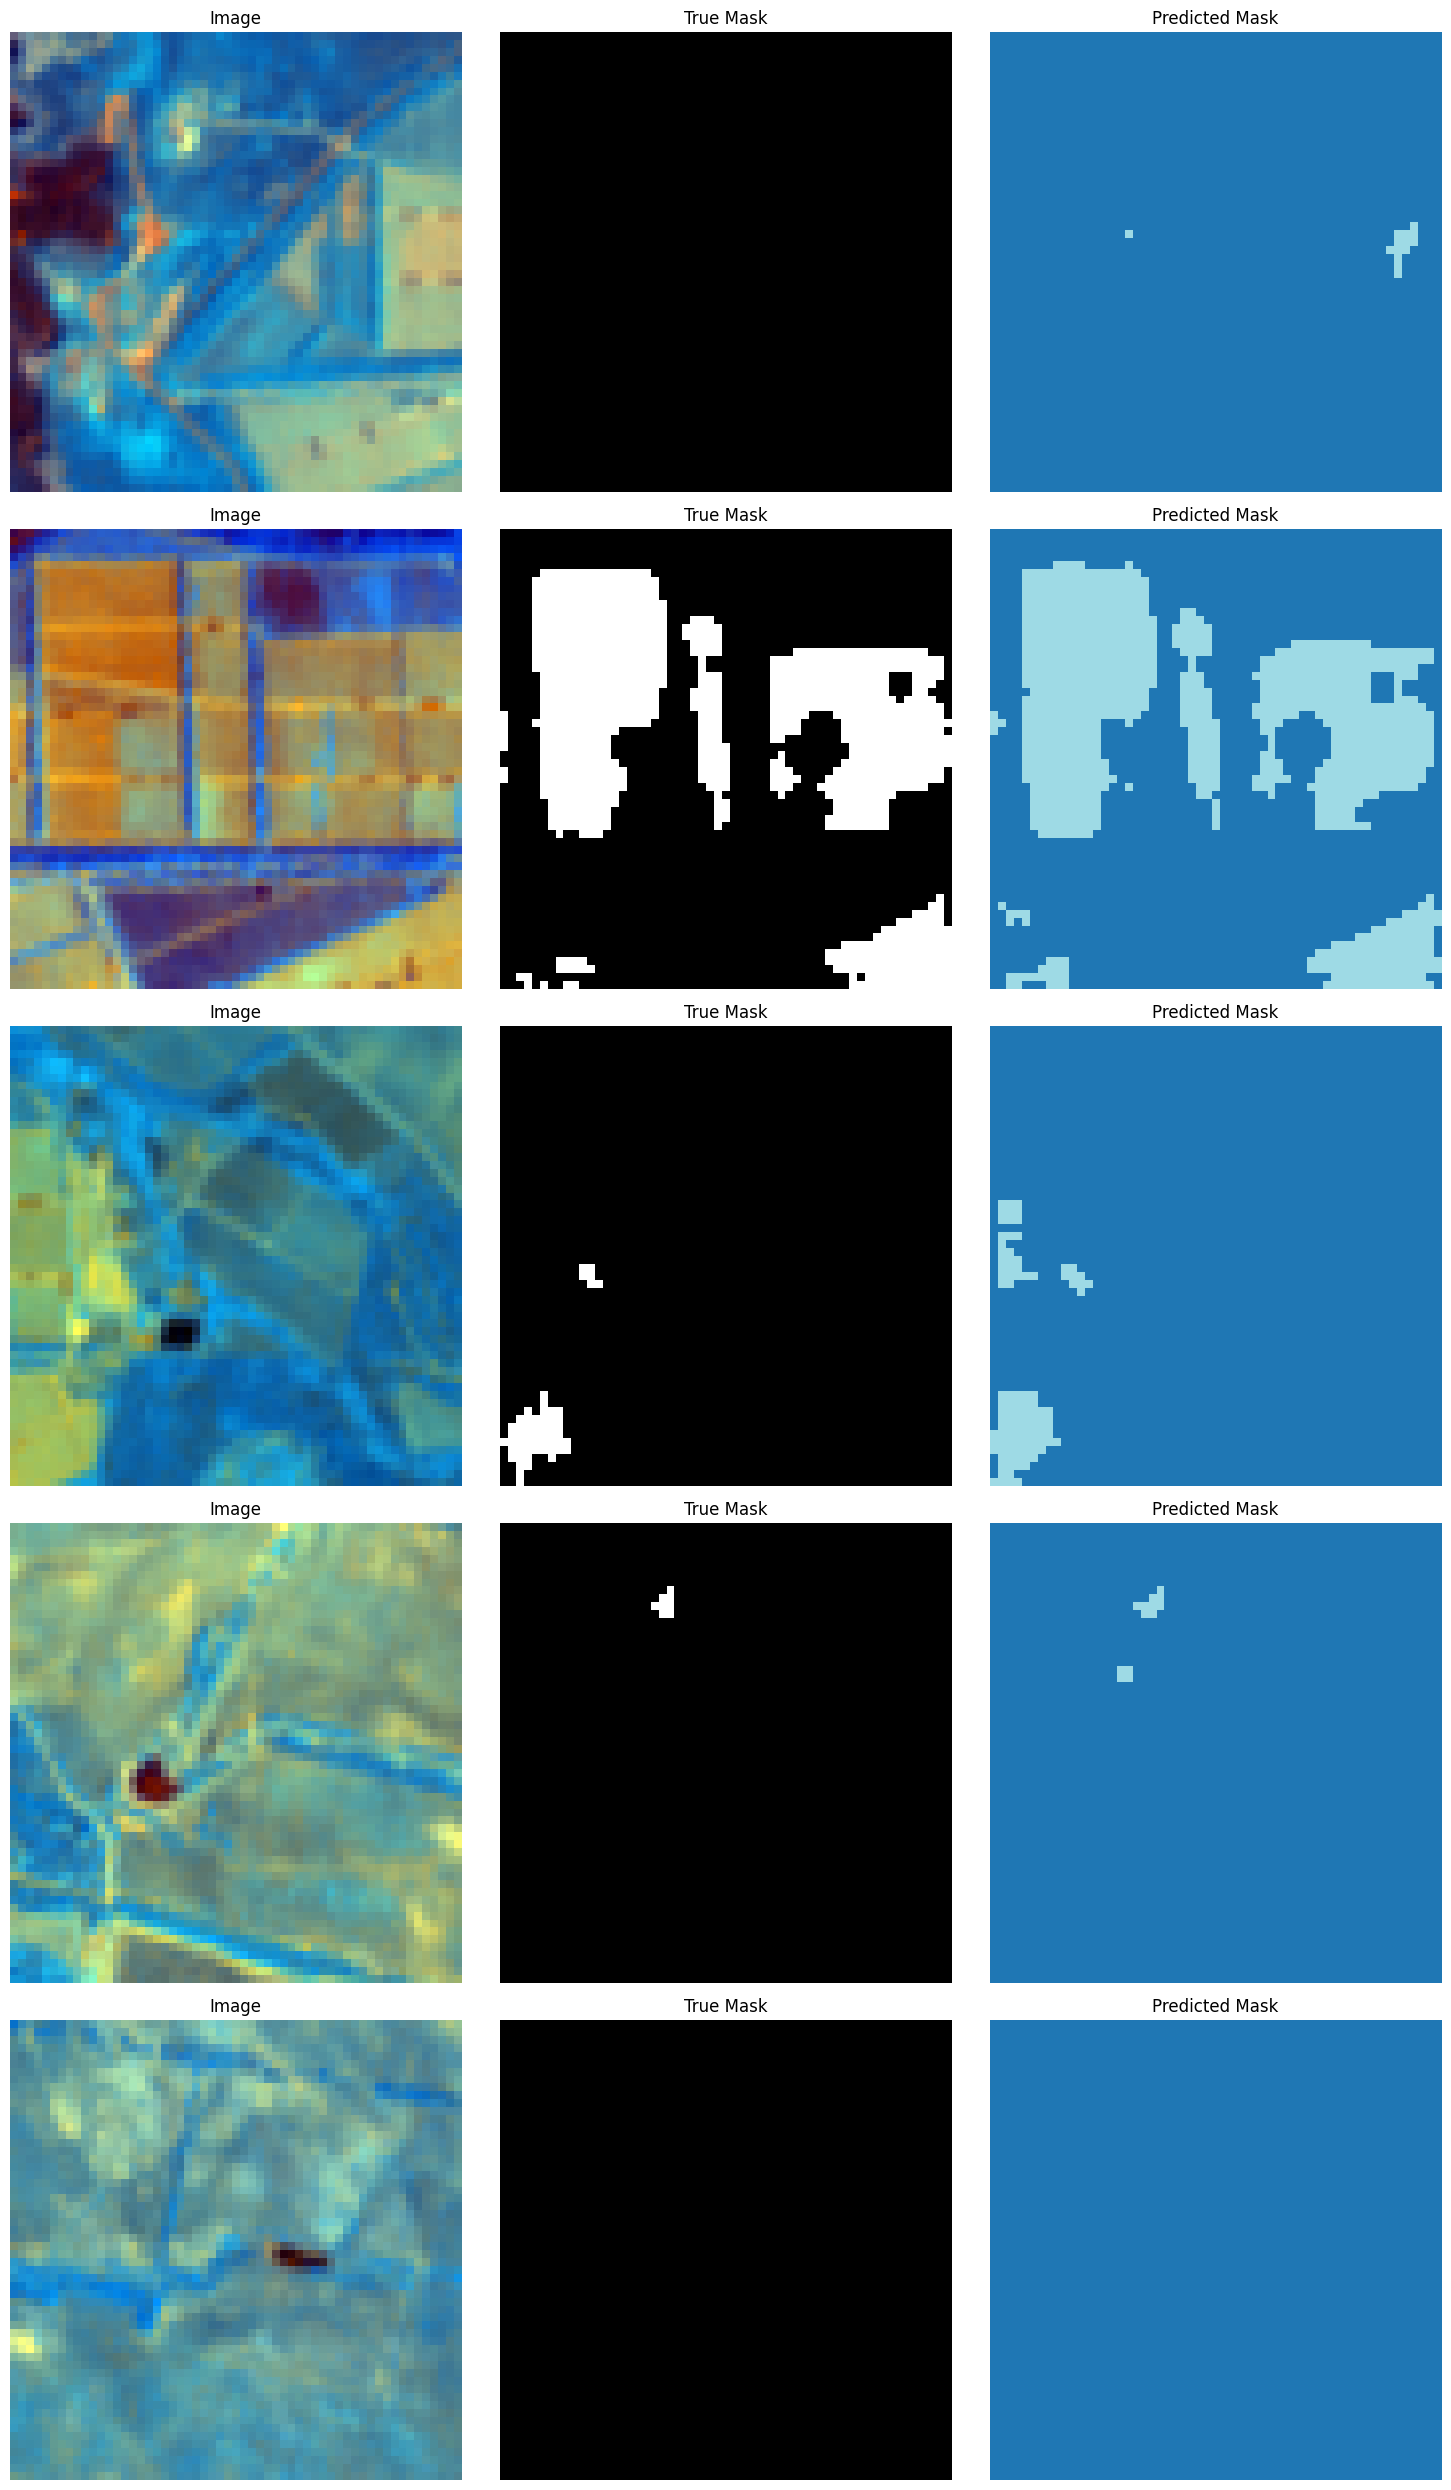

In [9]:
# Display sample predictions
sample_indices = [0, 1, 2, 3, 4]

# Define the number of columns (including both true and predicted masks)
num_columns = 3

fig, axes = plt.subplots(len(sample_indices), num_columns, figsize=(15, 5 * len(sample_indices)))

for i, idx in enumerate(sample_indices):
    sample_image_path = list(test_dl.items)[idx]
    sample_image = PILImage.create(sample_image_path)
    sample_pred = preds[idx].argmax(dim=0).numpy()

    # Load the ground truth mask for the sample
    row, column = get_row_column_from_filename(sample_image_path)
    mask_file = os.path.join(mask_folder, f'row_{row}', f'image_{row}_{column}_mask1.png')
    true_mask = np.array(Image.open(mask_file))

    # image of satelite aggregate
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # image of true mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    # image of predicted mask
    axes[i, 2].imshow(sample_pred, cmap='tab20')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

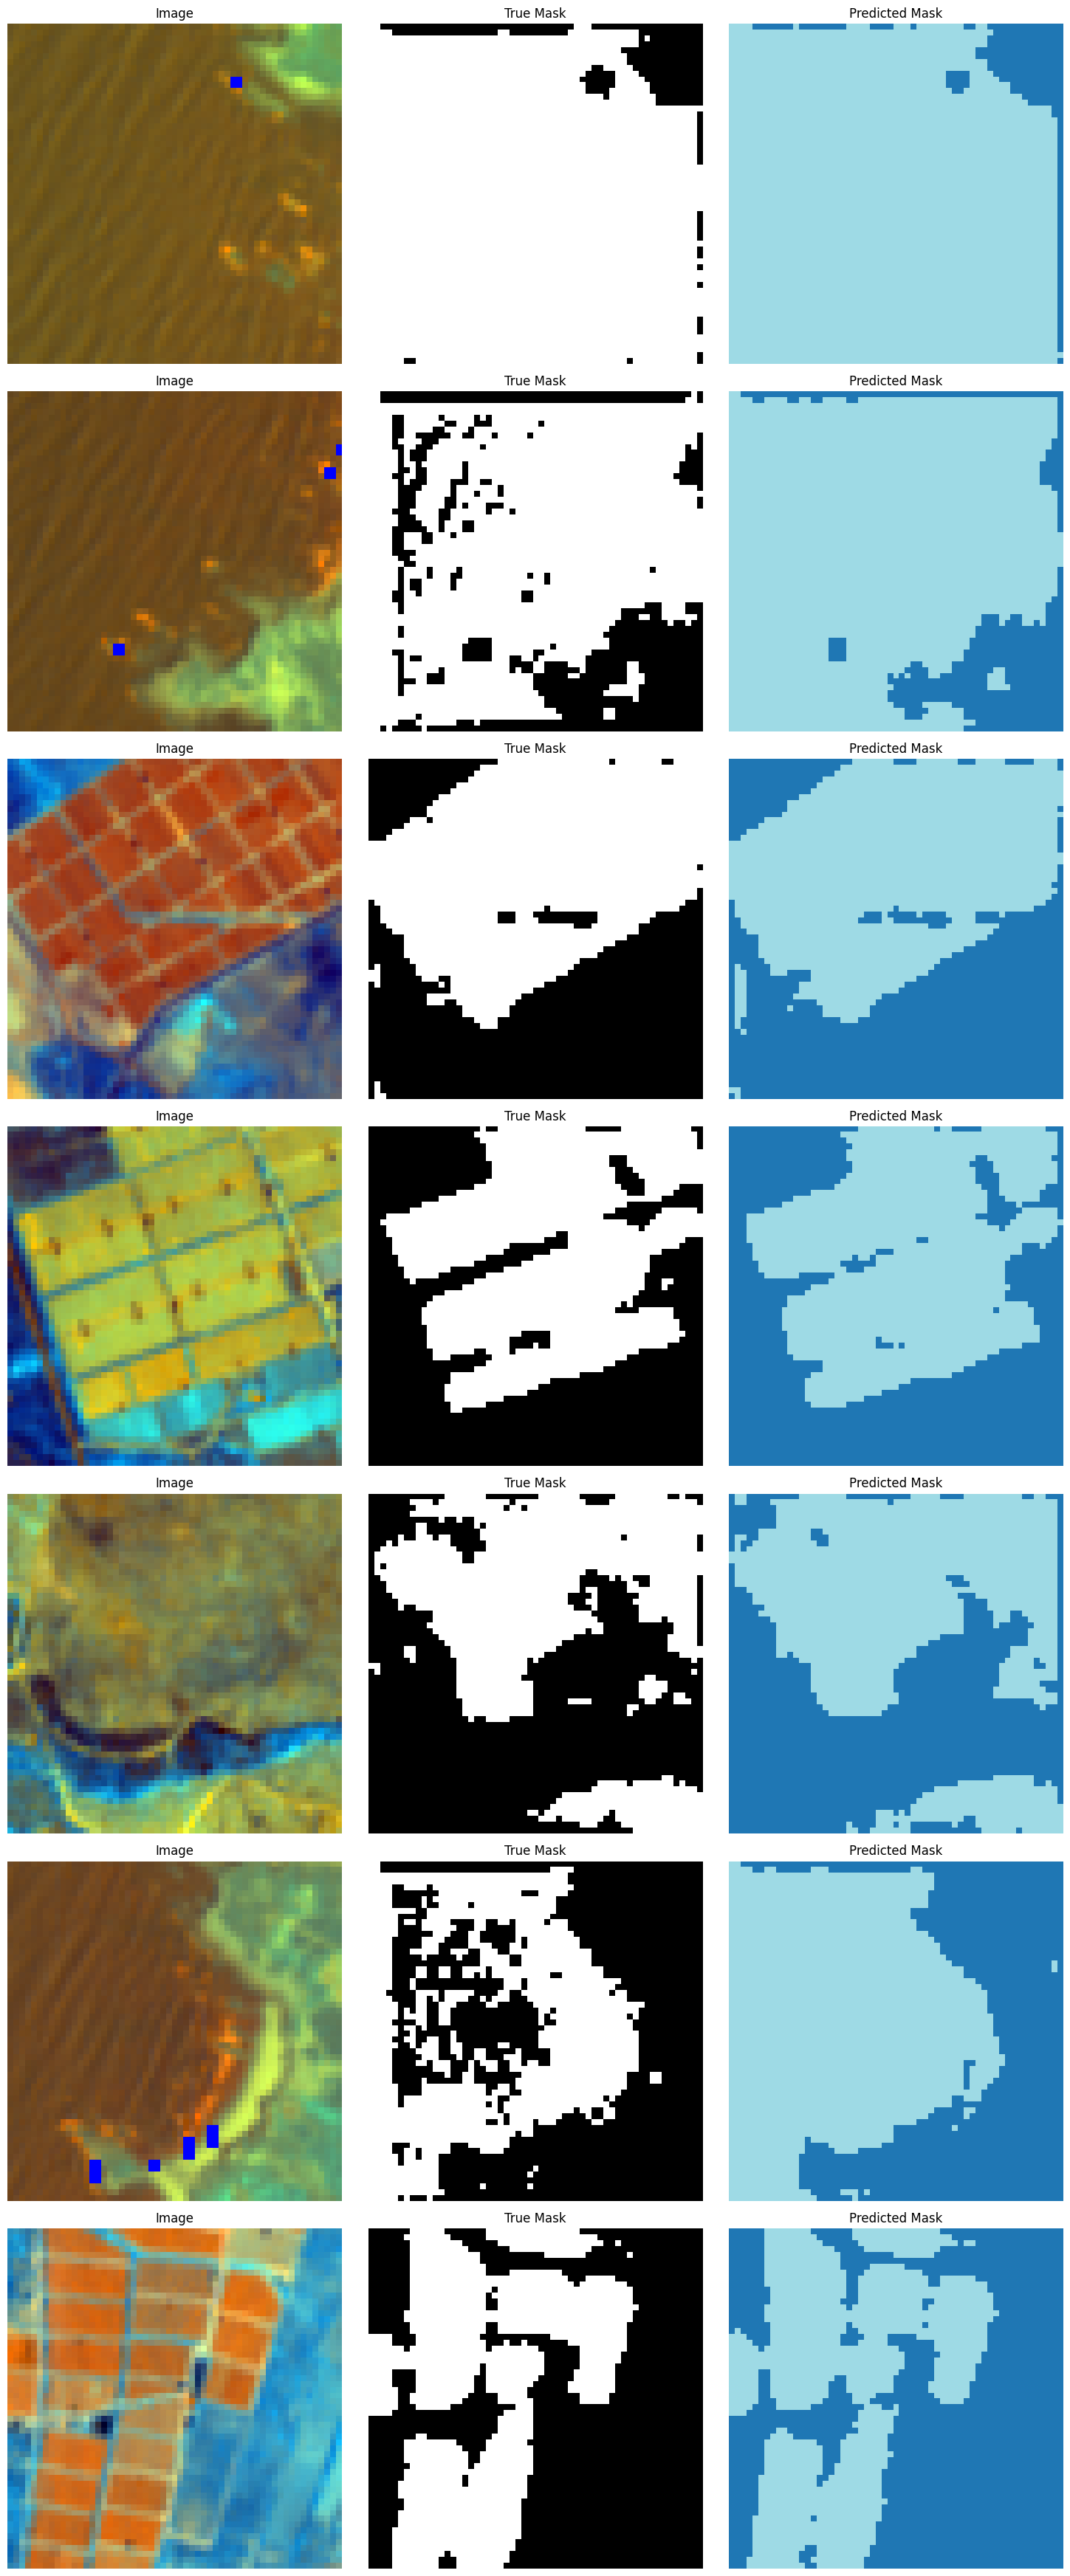

In [11]:
# Calculate errors for each block
errors = []

for idx, pred in enumerate(preds):
    # Get the row and column number from the test image file name
    sample_image_path = list(test_dl.items)[idx]
    row, column = get_row_column_from_filename(sample_image_path)

    # Load the corresponding ground truth mask for the test block
    mask_file = os.path.join(mask_folder, f'row_{row}', f'image_{row}_{column}_mask1.png')
    true_mask = np.array(Image.open(mask_file))

    # Convert the predicted mask to (N, 1, H, W) format
    pred_mask_reshaped = pred[0].unsqueeze(0).unsqueeze(0)  # Convert to (N, 1, H, W)

    # Resize the predicted mask to match the ground truth mask dimensions
    pred_mask_resized = torch.nn.functional.interpolate(pred_mask_reshaped, size=(true_mask.shape[0], true_mask.shape[1]), mode='nearest')
    pred_mask_resized = pred_mask_resized.squeeze(0).squeeze(0).numpy()  # Convert back to numpy array

    # Calculate the pixel-wise absolute difference between the true and predicted masks
    error = np.abs(true_mask.astype(int) - pred_mask_resized.astype(int)).sum()

    # Add the error and the block index to the list
    errors.append((error, idx))

# Sort the errors in descending order to get the blocks with the biggest errors
errors.sort(reverse=True)

# Get the indices of the five blocks with the biggest errors
blocks_with_biggest_errors = [idx for _, idx in errors[:7]]

# Display the five blocks with the biggest errors
fig, axes = plt.subplots(len(blocks_with_biggest_errors), 3, figsize=(15, 5 * len(blocks_with_biggest_errors)))

for i, idx in enumerate(blocks_with_biggest_errors):
    sample_image_path = list(test_dl.items)[idx]
    sample_image = PILImage.create(sample_image_path)
    sample_pred = preds[idx].argmax(dim=0).numpy()

    # Load the ground truth mask for the sample
    row, column = get_row_column_from_filename(sample_image_path)
    mask_file = os.path.join(mask_folder, f'row_{row}', f'image_{row}_{column}_mask1.png')
    true_mask = np.array(Image.open(mask_file))

    # image of satelite aggregate
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # image of true mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    # image of predicted mask
    axes[i, 2].imshow(sample_pred, cmap='tab20')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


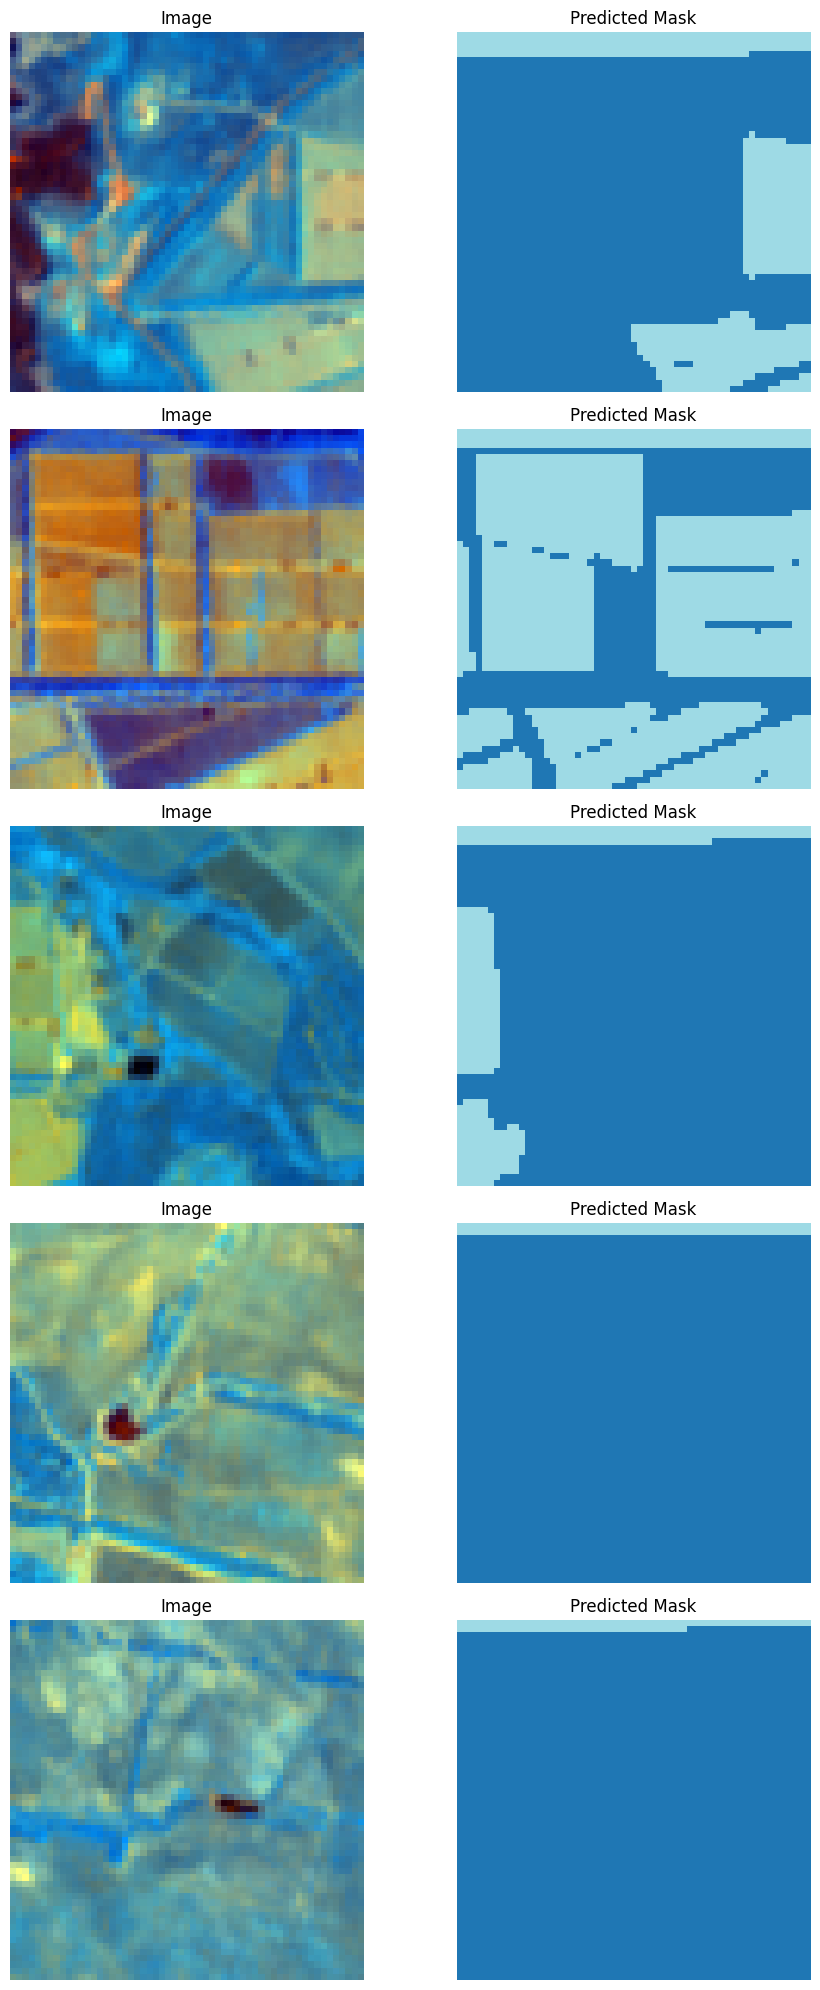

In [ ]:

# Display sample predictions
sample_indices = [0, 1, 2, 3, 4]

# Define the number of columns
fig, axes = plt.subplots(len(sample_indices), 2, figsize=(10, 20))

for i, idx in enumerate(sample_indices):
    sample_image_path = list(test_dl.items)[idx]
    sample_image = PILImage.create(sample_image_path)
    sample_pred = preds[idx].argmax(dim=0).numpy()
# image of satelite agregate
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
# image of predicted mask
    axes[i, 1].imshow(sample_pred, cmap='tab20')
    axes[i, 1].set_title('Predicted Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Confusion Matrix for training and test

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Perform inference on the test set
preds, _ = learn.get_preds(dl=dls.valid)

# Convert the predicted masks to a numpy array
predicted_masks = preds.argmax(dim=1).numpy()

# Get the ground truth masks for the test set
true_masks = [y for _, y in dls.valid]

# Convert the list of masks to a numpy array
true_masks = torch.cat(true_masks).cpu().numpy()
#true_masks = torch.cat(true_masks).numpy()


# Flatten the masks to be 1D arrays
true_masks_flat = true_masks.ravel()
predicted_masks_flat = predicted_masks.ravel()

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(true_masks_flat, predicted_masks_flat)

print("Confusion Matrix for the Test Set:")
print(conf_matrix)




Confusion Matrix for the Test Set:
[[93264  3515]
 [ 5159  3854]]


In [ ]:
# Perform inference on the training set
preds, _ = learn.get_preds(dl=dls.train)

# Convert the predicted masks to a numpy array
predicted_masks = preds.argmax(dim=1).numpy()

# Get the ground truth masks for the training set
true_masks = [y for _, y in dls.train]

# Convert the list of masks to a numpy array
true_masks = torch.cat(true_masks).cpu().numpy()
#true_masks = torch.cat(true_masks).numpy()

# Flatten the masks to be 1D arrays
true_masks_flat = true_masks.ravel()
predicted_masks_flat = predicted_masks.ravel()

# Calculate the confusion matrix for the training set
conf_matrix = confusion_matrix(true_masks_flat, predicted_masks_flat)

print("Confusion Matrix for the Training Set:")
print(conf_matrix)


Confusion Matrix for the Training Set:
[[307010  53320]
 [ 52427  10411]]


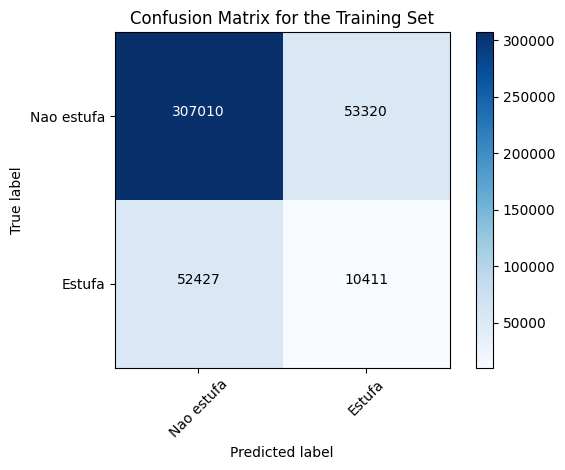

In [ ]:

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for the Training Set')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Fill in confusion matrix with values
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment='center',
             color='white' if conf_matrix[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()

## Model Accuracy for training and test

In [ ]:
# Perform inference on the training set
preds, _ = learn.get_preds(dl=dls.train)

# Convert the predicted masks to a numpy array
predicted_masks = preds.argmax(dim=1).numpy()

# Get the ground truth masks for the training set
true_masks = [y for _, y in dls.train]

# Convert the list of masks to a numpy array
true_masks = torch.cat(true_masks).cpu().numpy()

# Flatten the masks to be 1D arrays
true_masks_flat = true_masks.ravel()
predicted_masks_flat = predicted_masks.ravel()

# Calculate the total number of pixels
total_pixels = len(true_masks_flat)

# Calculate the number of correctly predicted pixels (True Positives + True Negatives)
correct_pixels = np.sum(true_masks_flat == predicted_masks_flat)

# Calculate the model accuracy
accuracy = correct_pixels / total_pixels

print("Model Accuracy for the Training Set: {:.2f}%".format(accuracy * 100))


Model Accuracy for the Training Set: 75.10%


In [ ]:
# Perform inference on the test set
preds, _ = learn.get_preds(dl=dls.valid)

# Convert the predicted masks to a numpy array
predicted_masks = preds.argmax(dim=1).numpy()

# Get the ground truth masks for the test set
true_masks = [y for _, y in dls.valid]

# Convert the list of masks to a numpy array
true_masks = torch.cat(true_masks).cpu().numpy()

# Flatten the masks to be 1D arrays
true_masks_flat = true_masks.ravel()
predicted_masks_flat = predicted_masks.ravel()

# Calculate the total number of pixels
total_pixels = len(true_masks_flat)

# Calculate the number of correctly predicted pixels (True Positives + True Negatives)
correct_pixels = np.sum(true_masks_flat == predicted_masks_flat)

# Calculate the model accuracy
accuracy = correct_pixels / total_pixels

print("Model Accuracy for the Test Set: {:.2f}%".format(accuracy * 100))


Model Accuracy for the Test Set: 91.80%


In [ ]:
# Calculate and print the classification report
target_names = ['not greenhouse', 'greenhouse']
report = classification_report(true_masks_flat, predicted_masks_flat, target_names=target_names)
print("\nClassification Report for the Training Set:")
print(report)


Classification Report for the Training Set:
                precision    recall  f1-score   support

not greenhouse       0.95      0.96      0.96     96779
    greenhouse       0.52      0.43      0.47      9013

      accuracy                           0.92    105792
     macro avg       0.74      0.70      0.71    105792
  weighted avg       0.91      0.92      0.91    105792

